In this notebook, we analyze an object in free fall under constant acceleration. As a first demonstration of the Kalman filter, there are no hidden variables. Said another way, the measurement vector are the same variables as the state vector.

In [1]:
using LinearAlgebra
using Random
using CairoMakie
using LaTeXStrings 

CairoMakie.activate!()

include("kalmanflt.jl");

The system is a particle falling due to gravity without air resistance. The equation of state are:

In [2]:
measurement = Vector{Float64}([1, 2])
obs_mat = zeros((2, 2));
obsCov_mat = zeros((2, 2))
obs = kfobservation{Float64}(obs_mat, obsCov_mat)

kfobservation{Float64}([0.0, 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0])

$$
\begin{align}
h &= h_{0} + v_{0} t + \frac{1}{2} a t^{2} \\
v &= v_{0} + a t
\end{align}
$$

In [3]:
time_steps = 125
delta_time_sec = 0.02  # sec
accel_ms2 = -9.8;  # meter / sec / sec

In [4]:
"""
    get_model_estimate(initial_state, measurement_time_sec)

Assuming constant acceleration, compute how the position and velocity change from their initial state

# Arguments
- `initial_state::Vector`: Must be a 2-item vector exactly as `Vector{Float64}([p, v])` where `p` is the position and `v` is the velocity
- `measurement_time_sec::Number`: The number of seconds from the initial state

# Returns
`Vector` of the state estimate

# Examples
```jldoctest
julia> v = get_model_estimate(Vector([9.8, 0.]), sqrt(2.))
2-element Vector{Float64}:
  -1.7763568394002505e-15
 -13.859292911256333
```
"""
function get_model_estimate(
    initial_state::Vector,
    measurement_time_sec::Number)::Vector
    
    transition_mat = [1.0 measurement_time_sec; 
                      0.0 1.0]
    external_input_vector = Vector([1, 1]) .* accel_ms2
    control_mat = [0.5 * measurement_time_sec^2 0.0; 
                   0.0 measurement_time_sec]
    return ((transition_mat * initial_state)
            + (control_mat * external_input_vector))
end;

Initialize the initial and true states

In [5]:
initial_state_vector = Vector([1000., -0.01])
true_state_vector = Vector([1015., 2.5]);

Populate an array of the true state evolution in time

In [6]:
true_state_fcn_time = zeros(Float64, (2, time_steps))
for time_step_index = 1:time_steps
    time_sec = delta_time_sec * (time_step_index - 1)
    true_state_fcn_time[:, time_step_index] = get_model_estimate(true_state_vector, time_sec)
end;

Plot the true position

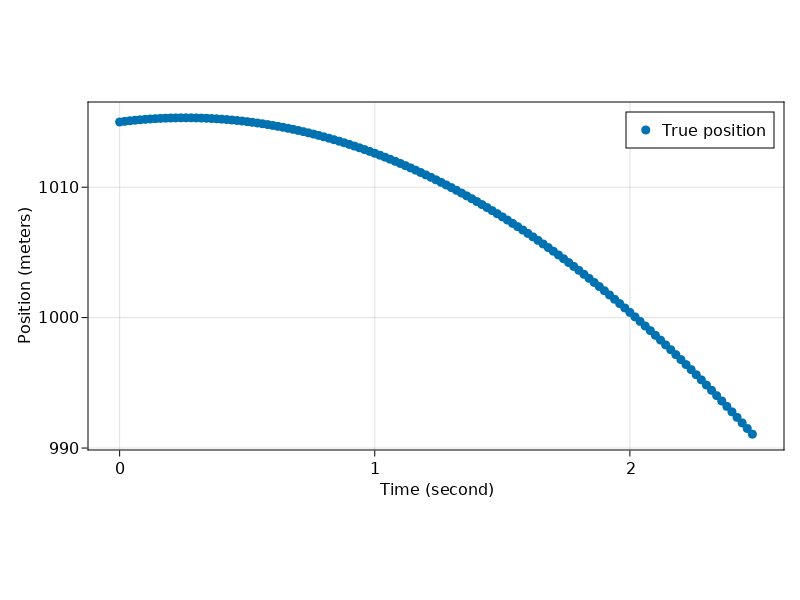

In [7]:
time_axis_sec = [delta_time_sec * (t-1) for t in 1:time_steps]


scatter(
    time_axis_sec,
    true_state_fcn_time[1, :],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Position (meters)"),
    label="True position"
)
lines!(
    time_axis_sec,
    true_state_fcn_time[1, :]
)
axislegend()
current_figure()


Plot the true velocity

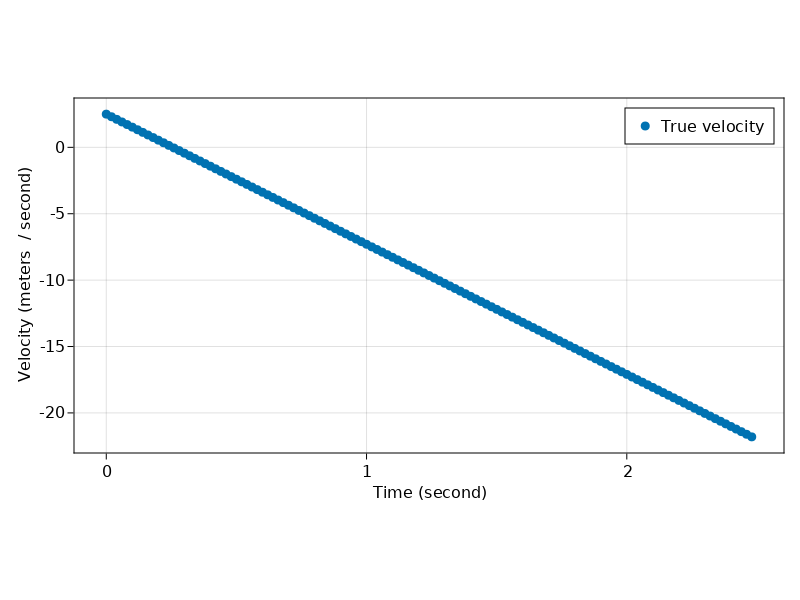

In [8]:
scatter(
    time_axis_sec,
    true_state_fcn_time[2, :],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Velocity (meters  / second)"),
    label="True velocity"
)
lines!(
    time_axis_sec,
    true_state_fcn_time[2, :]
)
axislegend()
current_figure()

In [9]:
"""
    get_measurement(true_state, measurement_time_sec)

Simulate the measurement at the specified time given the true state. Artificial noise is added to simulate a real system

# Arguments
- `true_state::Vector`: Must be a 2-item vector exactly as `Vector{Float64}([p, v])` where `p` is the position and `v` is the velocity
- `measurement_time_sec::Number`: The number of seconds from the true starting state

# Returns
`Vector` of the measurement

See also [`get_model_estimate`](@ref) for an example
"""
function get_measurement(
    true_state::Vector,
    measurement_time_sec)::Vector
    """Get the next measurement
    In a 'real' physical system, we would not need to simulate the measurement
    """

    model_estimate_vec = get_model_estimate(
        true_state, measurement_time_sec
    )
    # Pseudo-measurement using classical physics calculation with noise
    position_noise_m = 1.0  # meter
    velocity_noise_ms = 0.5  # meter / sec
    artificial_noise_vec = Vector([position_noise_m, velocity_noise_ms]) .* rand(2)
    measurement::Vector = model_estimate_vec + artificial_noise_vec
    return measurement
end;

The state vector is position, velocity. We will use very generous covariance values here as values too small provide no little room for the algorithm to work.

In [10]:
initial_state_cov = diagm([100.0^2, # meters^2
                              10.0^2])  # (meters / seconds)^2
initial_state = kfstate{Float64}(initial_state_vector, initial_state_cov);

In [11]:
state_transition_mat = [1.0 delta_time_sec; 
                        0.0 1.0]
control_mat = [0.5 * delta_time_sec^2 0; 
               0                      delta_time_sec]
system_noise_mat = [0.1  0.05;
                    0.05 0.01]
external_input_vector = Vector([accel_ms2, accel_ms2])
update_matices = kfupdate{Float64}(state_transition_mat, control_mat, system_noise_mat);

Initialize the observation matrix. The measurement and state is one-to-one. For the measurement, the variance for the position (velocity) is 100 meters-squared (1 meters-squared/sec-squared)

$$
\begin{align}
z_{n} &= H x_{n} \\
\begin{pmatrix}
h_{z_{n}} \\
v_{z_{n}}
\end{pmatrix} &= \begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}
\begin{pmatrix}
h_{x_{n}} \\
v_{x_{n}}
\end{pmatrix} \\
\text{cov}\left(z\right) &= 
\begin{pmatrix}
10^2 & 0 \\
0   & 5^2
\end{pmatrix}
\end{align}
$$

In [12]:
obs_mat = convert(Matrix{Float64}, I(2))
obsCov = diagm([10.0^2, 5.0^2])
observations = kfobservation{Float64}(obs_mat, obsCov);

Gather measurements and update the state

In [13]:
states_fcn_time = Vector{kfstate{Float64}}(undef, time_steps);
measurements = Array{Vector{Float64}}(undef, time_steps)
# This is the seed fo r the algorithm
next_state = kfstate{Float64}(initial_state.state, initial_state.cov)

for step in 1:time_steps
    # At current time, get measurement
    time_sec = (step - 1) * delta_time_sec
    measurement_vec = get_measurement(true_state_vector, time_sec)
    observations.meas = measurement_vec
    measurements[step] = measurement_vec
    true_state_vec = get_model_estimate(true_state_vector, time_sec)

    # Predict the next state
    predicted_state = predict_state(next_state, update_matices, external_input_vector)

    # Update the estimate
    next_state = correct_state(predicted_state, observations)
    states_fcn_time[step] = next_state

end;

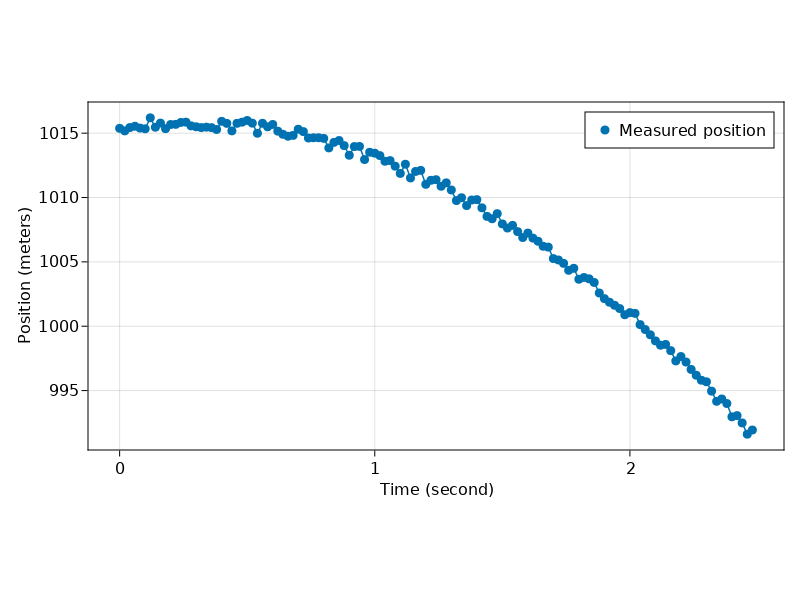

In [14]:
scatter(
    time_axis_sec,
    [measurements[step][1] for step in 1:time_steps],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Position (meters)"),
    label="Measured position"
)
lines!(time_axis_sec, [measurements[step][1] for step in 1:time_steps])
axislegend()
current_figure()

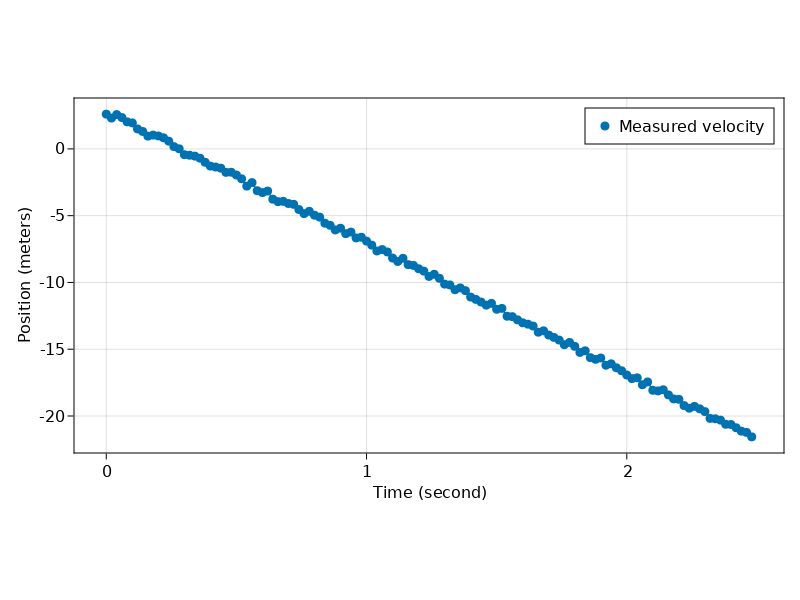

In [15]:
scatter(
    time_axis_sec,
    [measurements[step][2] for step in 1:time_steps],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Position (meters)"),
    label="Measured velocity"
)
lines!(time_axis_sec, [measurements[step][2] for step in 1:time_steps])
axislegend()
current_figure()

Plot the true and estimated position

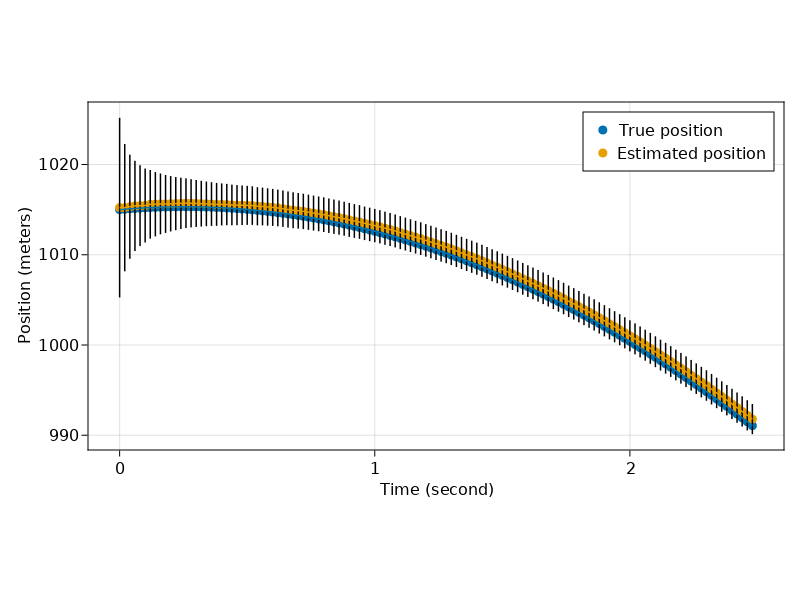

In [16]:
scatter(
    time_axis_sec,
    true_state_fcn_time[1, :],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Position (meters)"),
    label="True position"
)

scatter!(
    time_axis_sec,
    [s.state[1] for s in states_fcn_time],
    label="Estimated position"
)

errorbars!(
    time_axis_sec,
    [s.state[1] for s in states_fcn_time],
    [sqrt(s.cov[1, 1]) for s in states_fcn_time]
)

lines!(
    time_axis_sec,
    true_state_fcn_time[1, :]
)

lines!(
    time_axis_sec,
    [s.state[1] for s in states_fcn_time]
)
axislegend()
current_figure()


Plot the true and estimated velocity

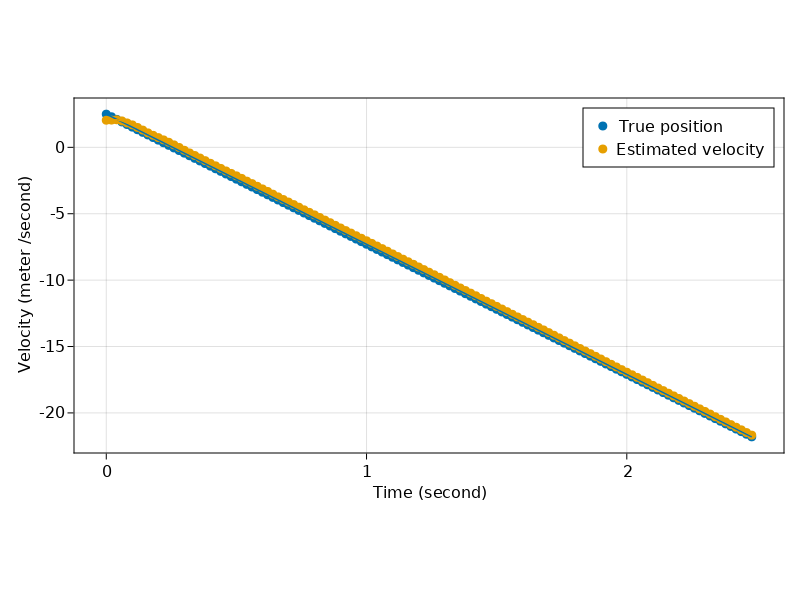

In [17]:
scatter(
    time_axis_sec,
    true_state_fcn_time[2, :],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Velocity (meter /second)"),
    label="True position"
)

scatter!(
    time_axis_sec,
    [s.state[2] for s in states_fcn_time],
    label="Estimated velocity"
)

lines!(
    time_axis_sec,
    true_state_fcn_time[2, :]
)

lines!(
    time_axis_sec,
    [s.state[2] for s in states_fcn_time]
)
axislegend()
current_figure()
